In [195]:
import asyncio
import json
from typing import List
from datetime import datetime, timedelta

from grpclib.client import Channel
from cortexadmin_pb import CortexAdminStub, SeriesRequest, QueryRangeRequest, QueryRequest, MatcherRequest
from betterproto.lib.google.protobuf import Empty

default_query_interval = "1m"

async def get_all_users(service: CortexAdminStub) -> List[str]:
  response = await service.all_user_stats(Empty())
  return [r.user_id for r in response.items]

async def list_all_metric(service: CortexAdminStub, cluster_id: str) -> List[str]:
  response = await service.extract_raw_series(MatcherRequest(tenant=cluster_id, match_expr=".+"))
  res = (json.loads(response.data.decode())["data"])
  s = set()
  for r in res["result"]:
    s.add(r["metric"]["__name__"])
  return list(s)

async def metric_query(service: CortexAdminStub, cluster_id: str, metric_name: str, namespace="opni"):
  query = f'sum(rate({metric_name}{{namespace="{namespace}"}}[{default_query_interval}])) by (pod)'
  response = await service.query(QueryRequest(tenants=[cluster_id], query=query))
  response = json.loads(response.data.decode())["data"]
  return response

async def metric_queryrange(service: CortexAdminStub, cluster_id: str, metric_name: str, namespace="opni", end_time : datetime = None, time_delta : timedelta= timedelta(minutes=60), step_minute : int = 1):
  query_interval = "2m"# f"{step_minute}m"
  query = f'sum(rate({metric_name}{{namespace="{namespace}"}}[{query_interval}])) by (pod)'
  if end_time is None:
    end_time = datetime.now()
  start_time = end_time - time_delta
  response = await service.query_range(QueryRangeRequest(tenants=[cluster_id], query=query, start=start_time, end=end_time, step=timedelta(minutes=step_minute)))
  response = json.loads(response.data.decode())["data"]
  return response

In [196]:
channel = Channel(host="localhost", port=11090) # url of opni-internal. can port-forward to localhost:11090
service = CortexAdminStub(channel)

Unclosed connection: Channel('localhost', 11090, ..., path=None)


In [197]:
import matplotlib.pyplot as plt
import numpy as np
def plt_plot(ts_data):
    # Plot the time series data
    plt.plot(ts_data)
    plt.title("Time Series Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()


In [198]:
from scipy.stats import ks_2samp
from collections import defaultdict

threshold = 0.01

def moving_average(data, window_size=2):
    data = np.array(data)

    weights = np.repeat(1.0, window_size) / window_size
    moving_avg = np.convolve(data, weights, 'valid')
    return moving_avg

def ks_anomaly_detection(metric_values: List[float], cut : int = 50):
    # metric_values = moving_average(metric_values)
    l1, l2 = metric_values[:cut], metric_values[cut:]
    ks_stat, p_value = ks_2samp(l1, l2)
    if p_value < threshold:
        return True, p_value
    else:
        return False, p_value

def zscore_anomaly_detection(metric_values: List[float]):
    mean = np.mean(metric_values)
    std_dev = np.std(metric_values)

    # set a threshold value
    threshold = 5

    # identify anomalies using z-score
    anomalies = []
    for x in metric_values:
        z_score = abs((x - mean) / std_dev)
        if z_score > threshold:
            anomalies.append(x)
    return anomalies

import time 

async def pull_metrics_data(end_time, service, user_id:str, metrics, ns="opni"):
    res = []
    for m in metrics:
        q1 = await metric_queryrange(service, user_id, m,end_time=end_time, time_delta=timedelta(minutes=300),step_minute=1, namespace=ns)
        res.append(q1)
    return res



In [199]:
cluster = 0
user_id = (await get_all_users(service))[cluster]
user_id
metrics = await list_all_metric(service, user_id)

fixed_ts = datetime.now()
fixed_ts

datetime.datetime(2023, 3, 22, 17, 52, 51, 460005)

In [200]:
cluster_ns = "default"
qs = await pull_metrics_data(fixed_ts, service, user_id, metrics, ns=cluster_ns)


metric_name: container_network_receive_packets_total, pod : currencyservice-b9b54f49d-7l8hs, rule3: False, rule4: False


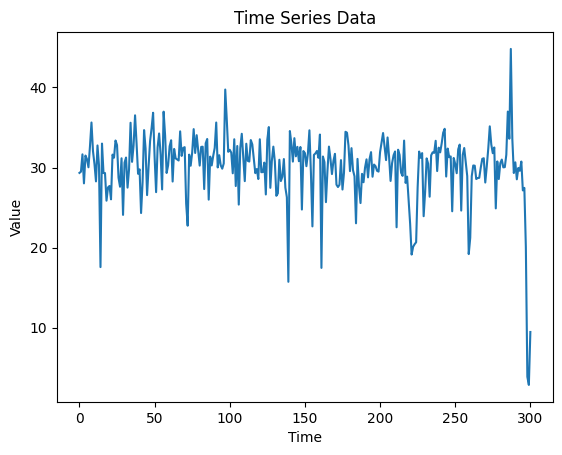

1
1171


In [201]:
imrpove_data = []
def process_task2(d, q1 ,m_name, is_debug = False):
    count = 0
    total = 0
    for r in q1["result"]:
        if "pod" not in r["metric"]:
            # print(r)
            continue
        pod = r["metric"]["pod"]
        # list0 = r["values"]
        values0 = [float(l[1]) for l in r["values"]]
        history, evaluate_window, test_window = values0[:240], values0[-60:], values0[-10:]
        try:
            is_anomaly, p_value = ks_anomaly_detection(evaluate_window)
            total += 1
            if is_anomaly:
                mean = np.mean(history)
                std_dev = np.std(history)
                std_multiplier = 3
                rule1 = max(test_window) > mean + std_multiplier * std_dev or min(test_window) < mean - std_multiplier * std_dev
                rule2 = max(test_window) > max(history) or min(test_window) < min(history)
                rule3 = np.mean(test_window) > mean + std_multiplier * std_dev or np.mean(test_window) < mean - std_multiplier * std_dev
                rule4, p_4 = ks_anomaly_detection(values0, cut=150)
                if rule1:# and rule3 and rule4: # rule1 and rule2
                    # z_s = zscore_anomaly_detection(values0)
                    # z_s_binary = True if len(z_s) > 0 else False
                    # if z_s_binary:
                    count += 1
                    d[pod+"-"+m_name] = values0[-60:]
                    imrpove_data.append(values0[-60:])
                    # if is_debug:
                    if True:
                        print(f"metric_name: {m_name}, pod : {pod}, rule3: {rule3}, rule4: {rule4}")
                        plt_plot(np.array(values0))
                        print("=====================")
        except Exception as e:
            pass
    s2 = time.time()
    return count, total

d = defaultdict(list)
total_count = 0
total = 0
for i,q in enumerate(qs):
    c, t = process_task2(d,q, metrics[i])
    total_count += c
    total += t
print(total_count)
print(total)
# print(imrpove_data)


In [191]:
if total_count > 50:
    with open("collected_data/" + str(fixed_ts.timestamp())+user_id+".data", 'w') as fout:
        fout.write(json.dumps(imrpove_data))

type1_steady_decrease


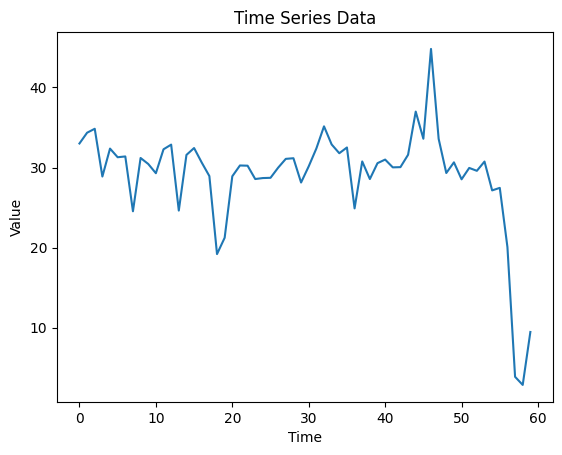

In [202]:
from model.cnn_model import MpcModel
from model.data_simulator import simulate_data, normalize_format
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')


def train_model():
    batch_size = 32
    train_data = simulate_data(1000)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batch = len(train_loader)
    n_epoch = 400 
    learning_rate = 0.001
    weight_decay = 0.0005 #1e-4, 1e-3, 1e-2

    seed = 1234
    np.random.seed(seed)

    model = MpcModel() # random initialization.
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for e in range(n_epoch):
        print(f"epoch : {e}")
        total_loss = 0
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(x_batch.to(device))
            loss = loss_fn(y_pred.cpu(), y_batch)
            # optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
        
        print(f"total loss : {total_loss}, average loss : {total_loss / total_batch}")

        ## eval?

    torch.save(model.state_dict() ,"model.pth")
    return model

def eval_model(test_data = None):
    if not test_data:
        test_data = simulate_data(100)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
    num_correct, num_total = 0, 0
    mistakes = []
    model = MpcModel()
    model = model.to(device)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            y_pred = model(x_batch.to(device))
            y_pred = torch.argmax(y_pred, dim=1).cpu()
            nc = torch.sum(y_pred == y_batch).item()
            num_correct += nc
            nt = y_batch.size(0)
            num_total += nt
            if nc == 0:
                mistakes.append(i)

    accuracy = num_correct / num_total
    print(f"accuracy : {accuracy}")
    print(f"mistakes : {mistakes}")
    print(len(mistakes))
    print(num_total)

def predict(pred_data):
    pred_data = [torch.tensor(np.array([normalize_format(p)]), dtype=torch.float32) for p in pred_data]
    test_loader = DataLoader(pred_data, batch_size=1, shuffle=False)
    model = MpcModel()
    model = model.to(device)
    model.load_state_dict(torch.load("model.pth" , map_location=torch.device('cpu')))
    model.eval()
    res = []

    with torch.no_grad():
        for i, x_batch in enumerate(test_loader):
            y_pred = model(x_batch.to(device))
            y_pred = torch.argmax(y_pred, dim=1).cpu()
            res.append(int(y_pred))
    return res

def normalize_format(ts_data):
    from sklearn.preprocessing import minmax_scale
    res = minmax_scale(ts_data)
    return res

pred_data0 = np.array([d[k] for k in d])


res = predict(pred_data0)

pred_map = {
      0: "type1_level_shift_up",
      1: "type1_level_shift_down",
      2: "type1_steady_increase",
      3: "type1_steady_decrease",
      4: "type1_sudden_increase",
      5:"type1_sudden_decrease",
      6: "type2_single_spike",
      7: "type2_single_dip",
      8: "type2_multi_spike",
      9:"type2_multi_dip",
      10:"type2_transient_level_up",
      11:"type2_transient_level_down",
      12: "type2_fluctuations",
}
res = [pred_map[r] for r in res]
for i, p in enumerate(pred_data0):
    print(res[i])
    plt_plot(p)


In [193]:
mx = [m for m in metrics if "http" in m]
mx

['prometheus_operator_kubernetes_client_http_requests_total',
 'prometheus_operator_kubernetes_client_http_request_duration_seconds_sum',
 'prometheus_sd_kubernetes_http_request_duration_seconds_sum',
 'prometheus_operator_kubernetes_client_http_request_duration_seconds_count',
 'prometheus_http_response_size_bytes_bucket',
 'kubelet_http_requests_duration_seconds_bucket',
 'prometheus_http_request_duration_seconds_sum',
 'kubelet_http_requests_total',
 'prometheus_http_requests_total',
 'prometheus_http_request_duration_seconds_count',
 'kubelet_http_requests_duration_seconds_sum',
 'promhttp_metric_handler_requests_total',
 'prometheus_sd_http_failures_total',
 'prometheus_http_request_duration_seconds_bucket',
 'promhttp_metric_handler_errors_total',
 'prometheus_sd_kubernetes_http_request_duration_seconds_count',
 'prometheus_http_response_size_bytes_sum',
 'kubelet_http_requests_duration_seconds_count',
 'opni_gateway_http_requests_total',
 'prometheus_http_response_size_bytes_cou

6165ba24-e496-491d-86f2-6eb083f24f0b
{'pod': 'adservice-656b4d5589-jlq5q'}


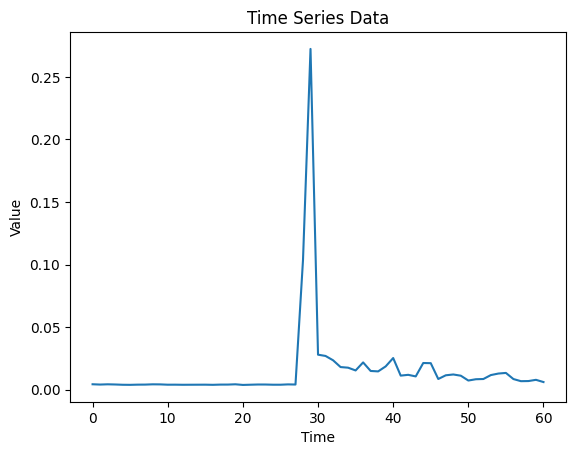

type2_single_spike
{'pod': 'cartservice-66bbd6c58f-9pfw6'}


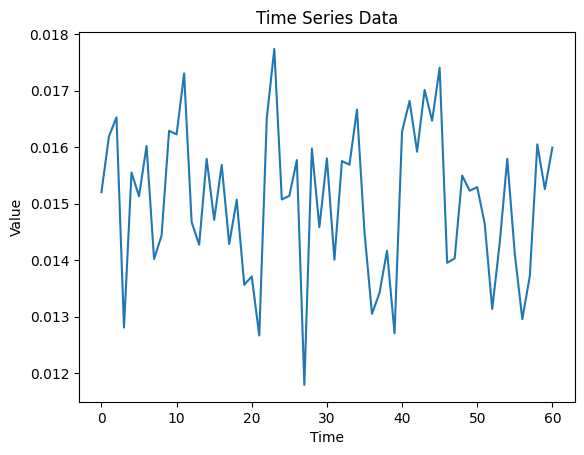

type2_fluctuations
{'pod': 'checkoutservice-75c548dc87-zvstd'}


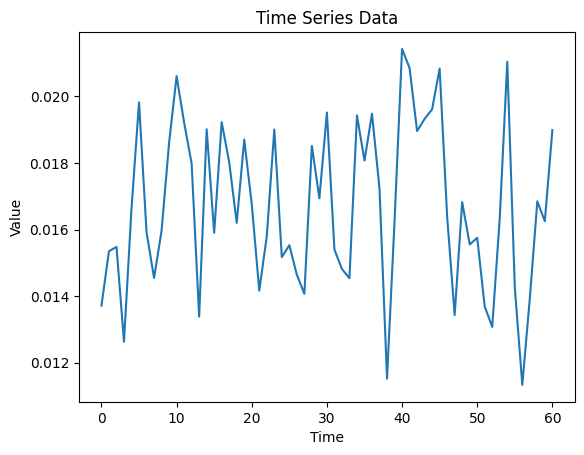

type2_fluctuations
{'pod': 'currencyservice-b9b54f49d-7l8hs'}


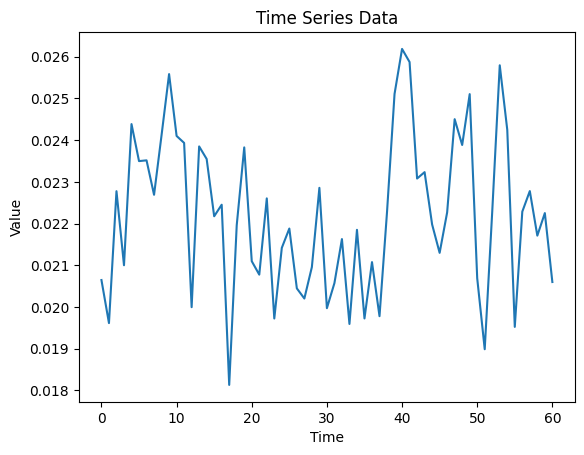

type2_fluctuations
{'pod': 'emailservice-76ff84977f-jd54x'}


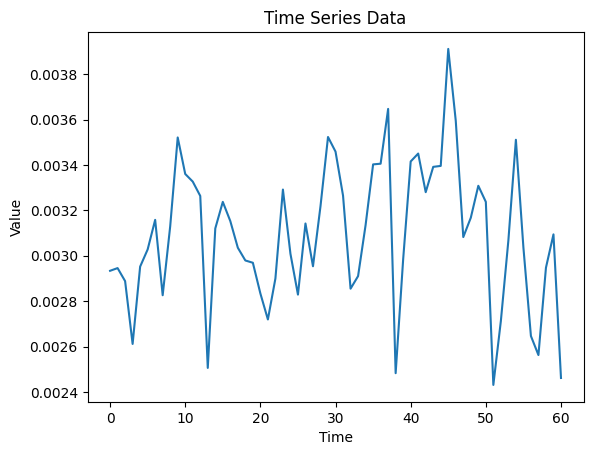

type2_fluctuations
{'pod': 'frontend-856b4cc48-8mlsf'}


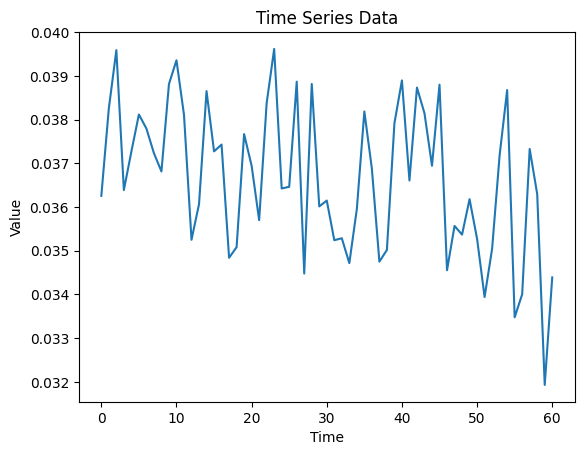

type2_fluctuations
{'pod': 'loadgenerator-547f6d9fbf-mf89s'}


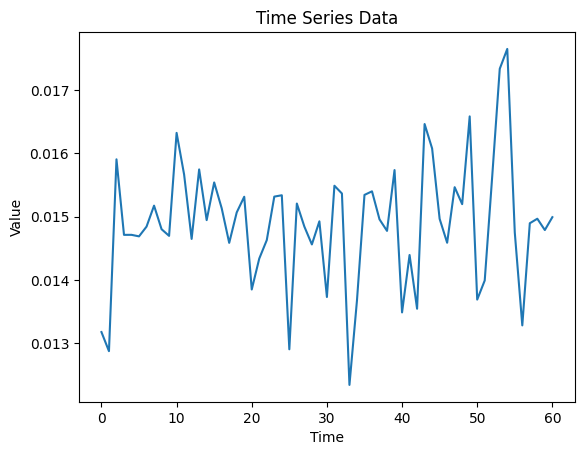

type2_fluctuations
{'pod': 'paymentservice-7b7859cf4f-zbbkd'}


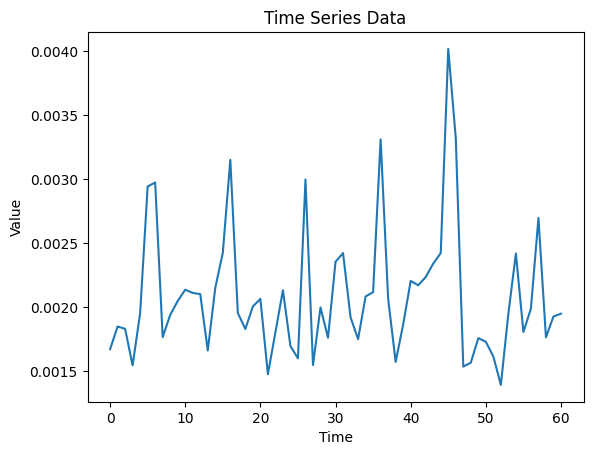

type2_multi_spike
{'pod': 'productcatalogservice-757df986cd-vc44s'}


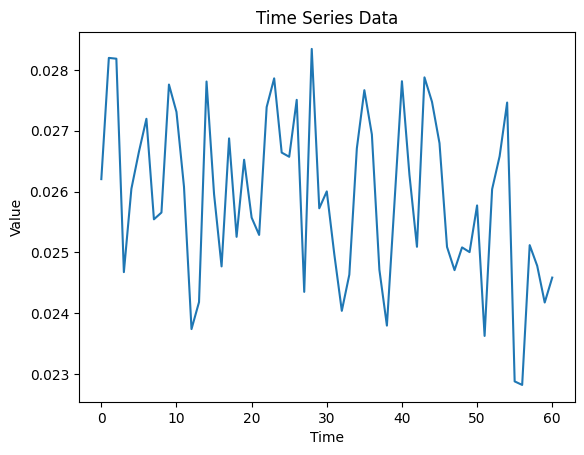

type2_fluctuations
{'pod': 'recommendationservice-587d67b8df-dvbgv'}


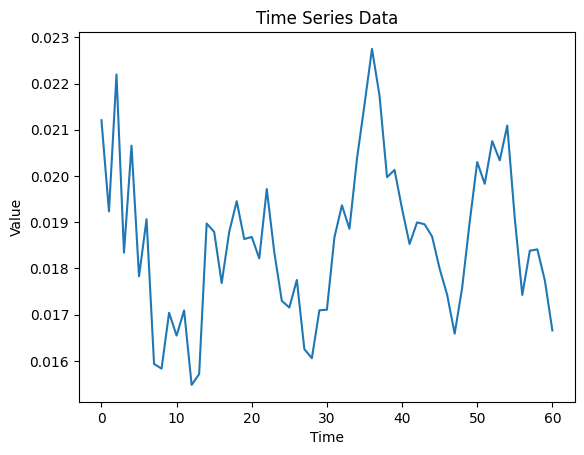

type2_fluctuations
{'pod': 'redis-cart-78746d49dc-fvz5h'}


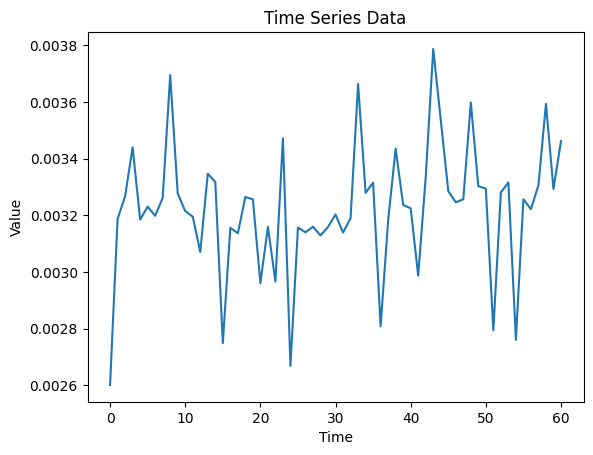

type2_fluctuations
{'pod': 'shippingservice-57cfb7d794-rxjnf'}


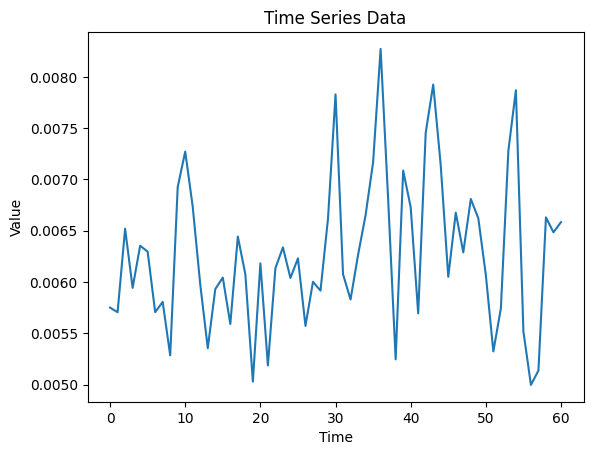

type2_fluctuations


In [194]:
# m = "container_network_receive_bytes_total"
m = "container_cpu_usage_seconds_total"
# m = 'container_memory_usage_bytes'
print(user_id)
res = await metric_queryrange(service, user_id, m, namespace="default")
res = res["result"]
res
for r in res:
    v = [float(x[1]) for x in r["values"]]
    print(r["metric"])
    plt_plot(v)
    pred = predict([v])
    print(pred_map[int(pred[0])])